Exploratory Data Analysis (EDA)

1. Import Library Python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
from wordcloud import WordCloud
from scipy.sparse import hstack
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

2. Load Dataset

In [2]:
df = pd.read_csv('data/tiktok_metadata.csv')

df.head()

,video_id,author,description,likes,comments,shares,plays,hashtags,music,create_time,video_url,fetch_time,views,posted_time
0,7506183500660313390,dalebrisby90,"That sounds like JB, ima go with TRUTH! 🤔🤣 #ro...",44800,125,1863,686000.0,"rodeotime, dalebrisby, jbmauney",original sound,2025-05-19 15:45:53,https://www.tiktok.com/@dalebrisby90/video/750...,NaN,NaN,NaN
1,7507316543605280030,jessicafloriolli,thanks for sticking around @Alonzofloriolli,285700,290,963,1200000.0,NaN,ECE Marketing Airball,2025-05-22 17:02:36,https://www.tiktok.com/@jessicafloriolli/video...,NaN,NaN,NaN
2,7507286333505719582,ay_2fya,#publicinterview #fyp #rizz,38000,65,496,416100.0,"publicinterview, fyp, rizz",original sound,2025-05-22 15:05:21,https://www.tiktok.com/@ay_2fya/video/75072863...,NaN,NaN,NaN
3,7506662216574209310,abell1823,Boat days hit different ✨,87200,259,23600,725800.0,NaN,If You Were Mine,2025-05-20 22:43:34,https://www.tiktok.com/@abell1823/video/750666...,NaN,NaN,NaN
4,7506628206280363310,jordanmarielynnxoxo,a lululemonnnn. #prettygirl #foryoupage #trend...,77600,724,1196,362100.0,"prettygirl, foryoupage, trending, likes",What Da Fuk,2025-05-20 20:32:12,https://www.tiktok.com/@jordanmarielynnxoxo/vi...,NaN,NaN,NaN


3. Memeriksa Struktur dan Tipe Data

In [3]:
# Untuk mengetahui ukuran dari dataset (jumlah baris dan kolom)
df.shape

(7225, 14)

In [4]:
# Untuk mengetahui informasi tentang tipe data dan jumlah nilai non-null di setiap kolom
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7225 entries, 0 to 7224
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   video_id     7225 non-null   int64  
 1   author       7225 non-null   object 
 2   description  6533 non-null   object 
 3   likes        7225 non-null   int64  
 4   comments     7225 non-null   int64  
 5   shares       7225 non-null   int64  
 6   plays        7218 non-null   float64
 7   hashtags     5150 non-null   object 
 8   music        7225 non-null   object 
 9   create_time  7218 non-null   object 
 10  video_url    7225 non-null   object 
 11  fetch_time   7 non-null      object 
 12  views        7 non-null      float64
 13  posted_time  7 non-null      object 
dtypes: float64(2), int64(4), object(8)
memory usage: 790.4+ KB


4. PreProcessing & Feature Enginering

In [5]:
df = df.drop(columns=['video_id', 'fetch_time', 'views', 'posted_time'])  # Hapus kolom tidak perlu


In [6]:
df = df.dropna(subset=['description', 'plays', 'author', 'music'])

le_author = LabelEncoder()
df['author_encoded'] = le_author.fit_transform(df['author'])

le_music = LabelEncoder()
df['music_encoded'] = le_music.fit_transform(df['music'])

df['description_length'] = df['description'].str.len()
df['description_word_count'] = df['description'].str.split().str.len()

df['create_time'] = pd.to_datetime(df['create_time'], errors='coerce')
df['hour'] = df['create_time'].dt.hour
df['day_of_week'] = df['create_time'].dt.dayofweek

df['popular'] = (df['plays'] >= 1_000_000).astype(int)

# TF-IDF
df['hashtags'] = df['hashtags'].fillna('')
tfidf = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf.fit_transform(df['hashtags'])

In [7]:
df[['likes', 'comments', 'shares', 'plays', 'description_length', 'description_word_count']].describe()

,likes,comments,shares,plays,description_length,description_word_count
count,6.527000e+03,6527.000000,6.527000e+03,6.527000e+03,6527.000000,6527.000000
mean,2.067071e+05,1958.980083,2.141476e+04,1.933366e+06,105.713191,14.828252
std,3.815642e+05,7677.059178,6.352958e+04,3.842329e+06,183.492398,29.838698
min,1.514000e+03,0.000000,1.300000e+01,1.408000e+05,1.000000,1.000000
25%,5.110000e+04,257.500000,1.092500e+03,5.029000e+05,37.000000,5.000000
50%,1.022000e+05,637.000000,4.548000e+03,8.963000e+05,70.000000,10.000000
75%,2.136500e+05,1630.000000,1.660000e+04,1.800000e+06,116.000000,15.000000
max,8.600000e+06,364300.000000,1.500000e+06,8.310000e+07,4011.000000,747.000000


5. Visualisasi Data

a. Visualisasi Distribusi Popularitas Menggunakan Bar Plot

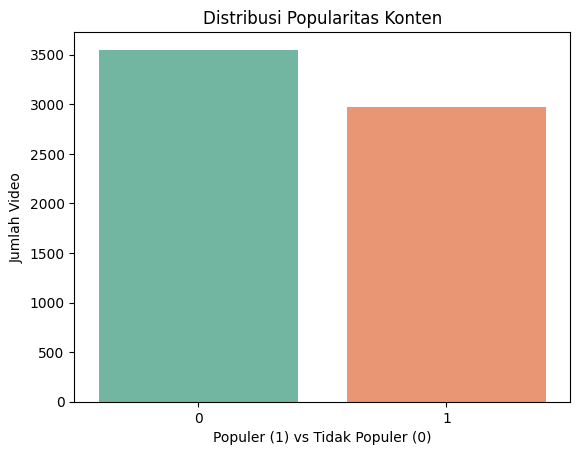

In [8]:
sns.countplot(x='popular', hue='popular', data=df, palette='Set2', legend=False)
plt.title('Distribusi Popularitas Konten')
plt.xlabel('Populer (1) vs Tidak Populer (0)')
plt.ylabel('Jumlah Video')
plt.show()

b. Boxplot Interaksi VS Popularitas

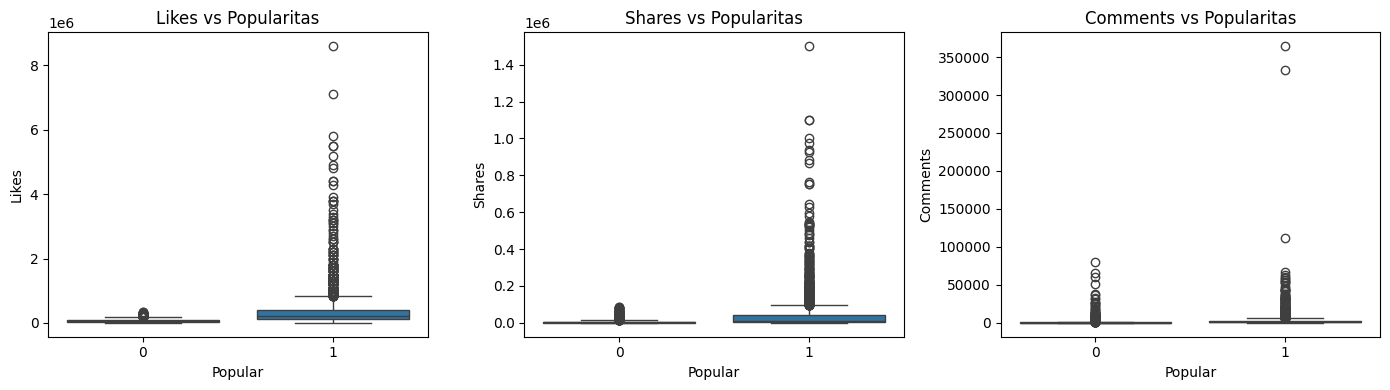

In [9]:
plt.figure(figsize=(14, 4))

for i, col in enumerate(['likes', 'shares', 'comments']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='popular', y=col, data=df)
    plt.title(f'{col.capitalize()} vs Popularitas')
    plt.xlabel('Popular')
    plt.ylabel(col.capitalize())

plt.tight_layout()
plt.show()


c. Visualisasi Distribusi Waktu Unggah (Jam)

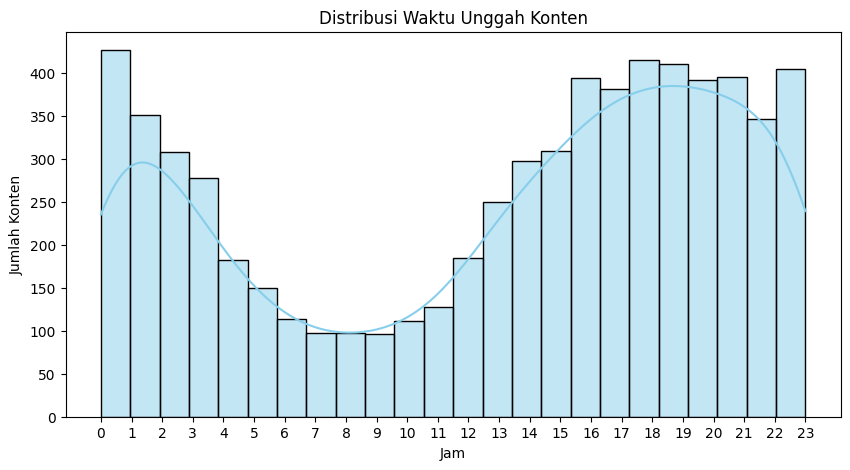

In [10]:
plt.figure(figsize=(10, 5))
sns.histplot(df['hour'].dropna(), bins=24, kde=True, color='skyblue')
plt.title('Distribusi Waktu Unggah Konten')
plt.xlabel('Jam')
plt.ylabel('Jumlah Konten')
plt.xticks(range(0, 24))
plt.show()


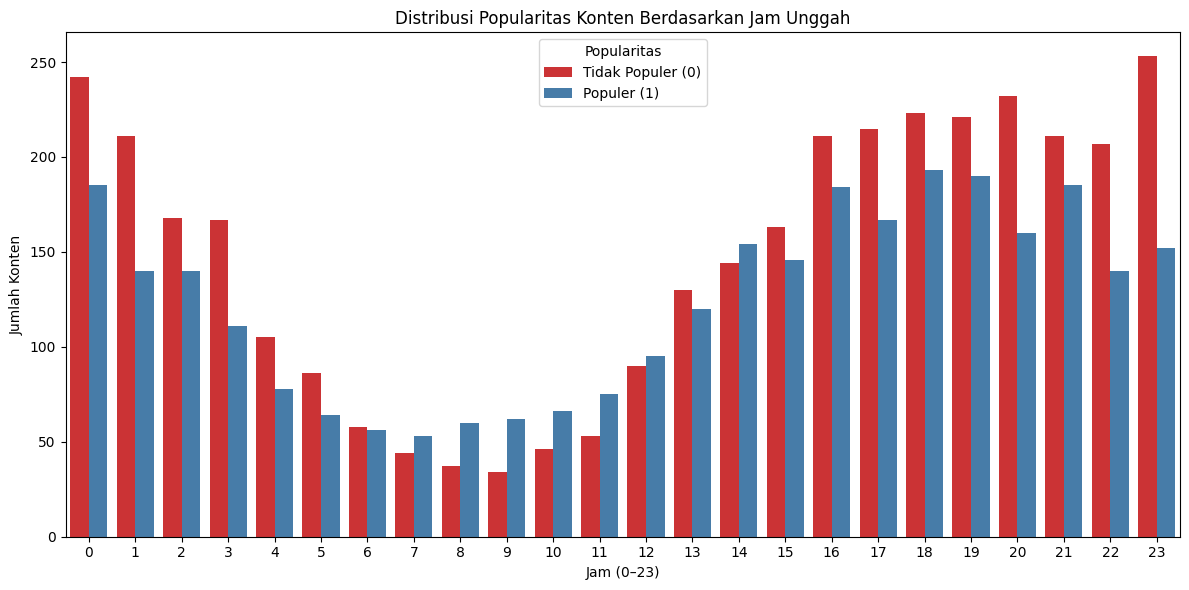

In [16]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='hour', hue='popular', palette='Set1')
plt.title('Distribusi Popularitas Konten Berdasarkan Jam Unggah')
plt.xlabel('Jam (0–23)')
plt.ylabel('Jumlah Konten')
plt.legend(title='Popularitas', labels=['Tidak Populer (0)', 'Populer (1)'])
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


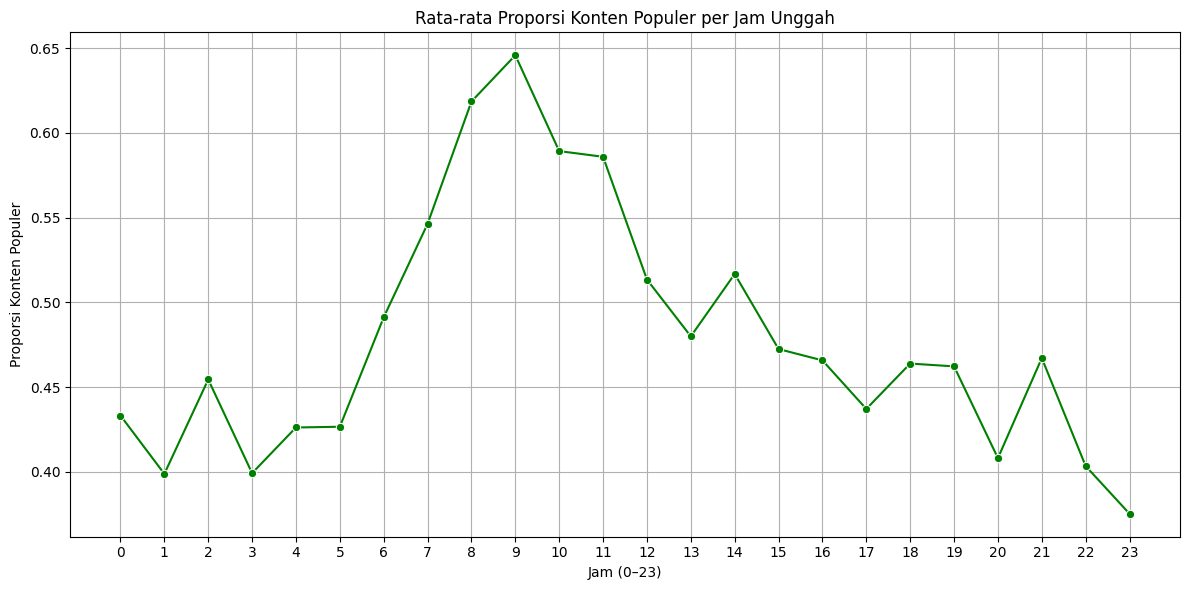

In [17]:
hour_popularity = df.groupby('hour')['popular'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=hour_popularity, x='hour', y='popular', marker='o', color='green')
plt.title('Rata-rata Proporsi Konten Populer per Jam Unggah')
plt.xlabel('Jam (0–23)')
plt.ylabel('Proporsi Konten Populer')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()


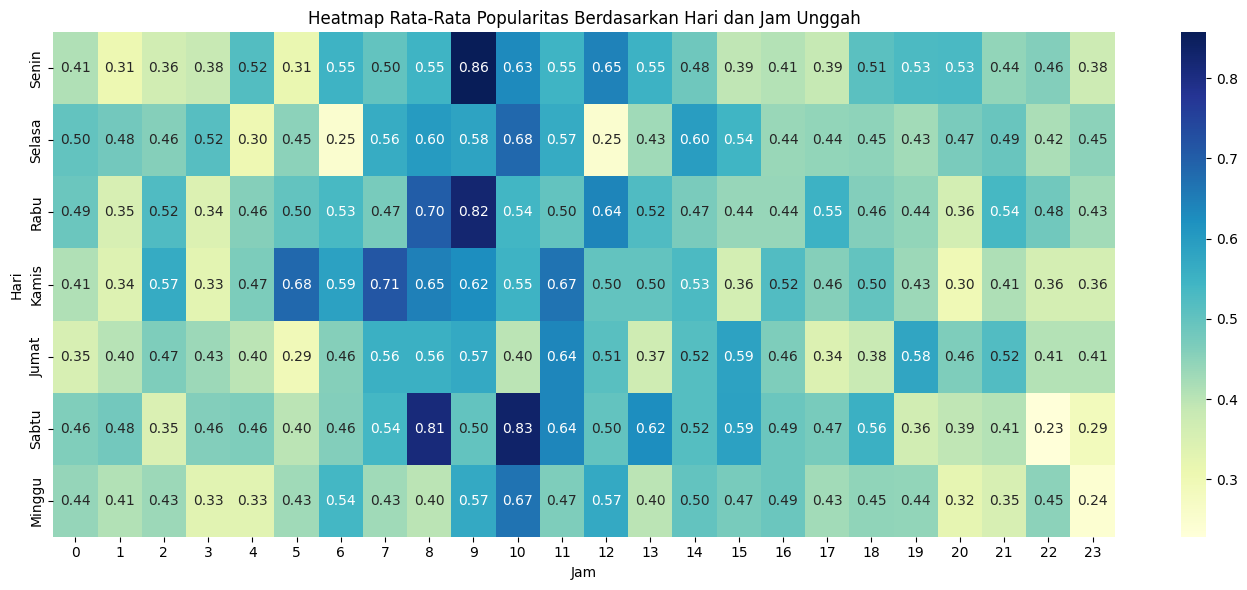

In [18]:
# Hitung rata-rata popularitas per kombinasi hari dan jam
pivot_table = df.pivot_table(index='day_of_week', columns='hour', values='popular', aggfunc='mean')

# Label hari dalam Bahasa Indonesia
day_labels = ['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat', 'Sabtu', 'Minggu']
pivot_table.index = [day_labels[i] for i in pivot_table.index]

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt='.2f')
plt.title('Heatmap Rata-Rata Popularitas Berdasarkan Hari dan Jam Unggah')
plt.xlabel('Jam')
plt.ylabel('Hari')
plt.tight_layout()
plt.show()


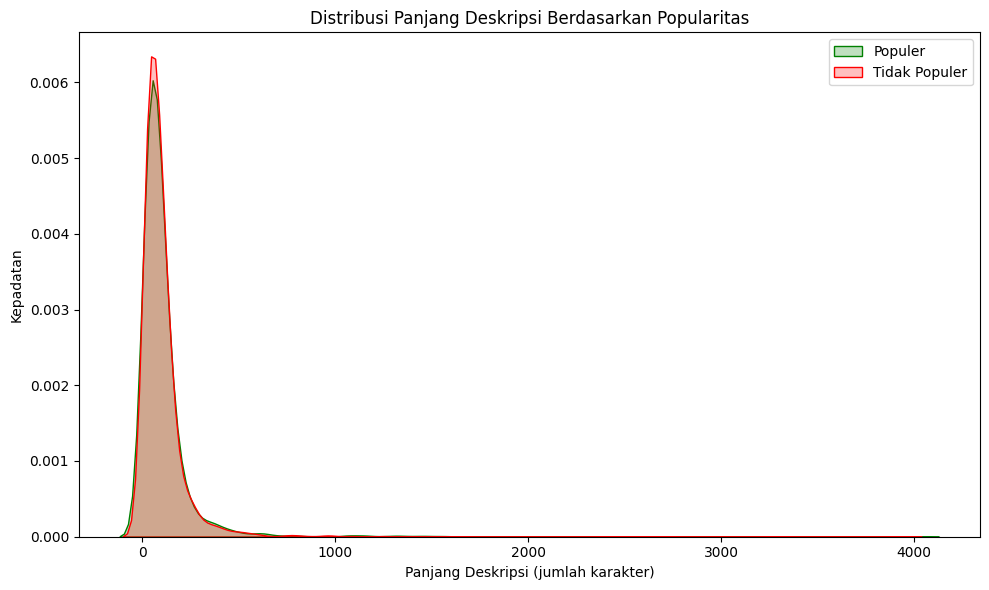

In [23]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df[df['popular'] == 1]['description_length'], label='Populer', fill=True, color='green')
sns.kdeplot(data=df[df['popular'] == 0]['description_length'], label='Tidak Populer', fill=True, color='red')
plt.title('Distribusi Panjang Deskripsi Berdasarkan Popularitas')
plt.xlabel('Panjang Deskripsi (jumlah karakter)')
plt.ylabel('Kepadatan')
plt.legend()
plt.tight_layout()
plt.show()

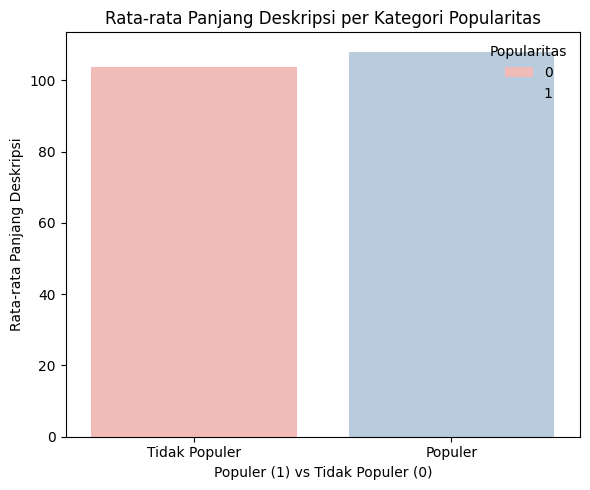

In [25]:
avg_desc = df.groupby('popular')['description_length'].mean().reset_index()

plt.figure(figsize=(6, 5))
sns.barplot(x='popular', y='description_length', data=avg_desc, palette='Pastel1', hue='popular', dodge=False)
plt.title('Rata-rata Panjang Deskripsi per Kategori Popularitas')
plt.xlabel('Populer (1) vs Tidak Populer (0)')
plt.ylabel('Rata-rata Panjang Deskripsi')
plt.xticks([0, 1], ['Tidak Populer', 'Populer'])
plt.tight_layout()
plt.legend(title='Popularitas', loc='upper right', frameon=False)
plt.show()

d. Rata-Rata Interaksi Berdasarkan Hari

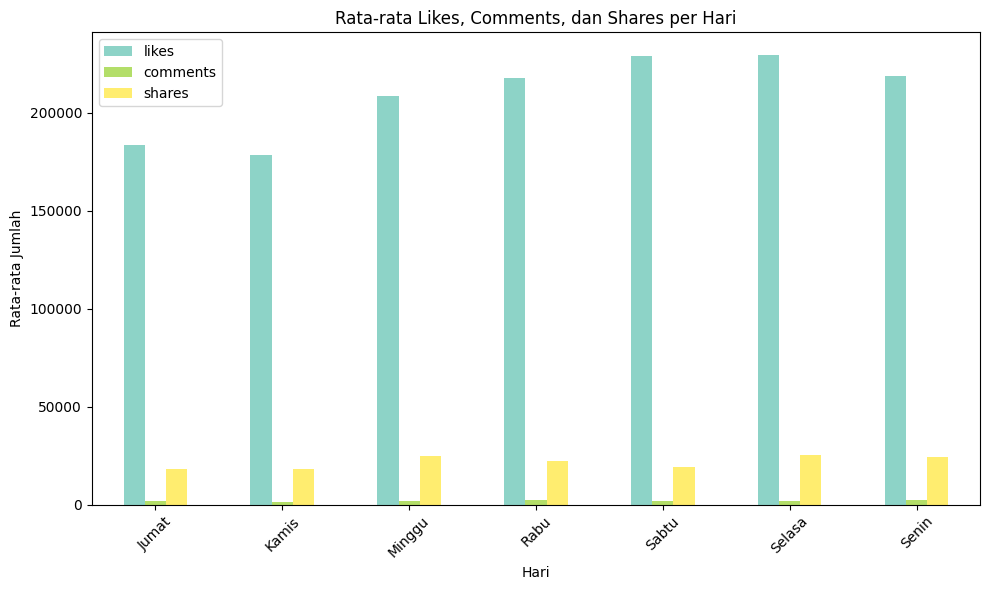

In [11]:
day_map = ['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat', 'Sabtu', 'Minggu']
df['day_of_week_str'] = df['day_of_week'].map(lambda x: day_map[int(x)] if pd.notnull(x) else 'Unknown')

avg_interactions = df.groupby('day_of_week_str')[['likes', 'comments', 'shares']].mean().reset_index()
avg_interactions = avg_interactions.sort_values('day_of_week_str')

avg_interactions.plot(x='day_of_week_str', kind='bar', figsize=(10,6), colormap='Set3')
plt.title('Rata-rata Likes, Comments, dan Shares per Hari')
plt.ylabel('Rata-rata Jumlah')
plt.xlabel('Hari')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


f. Visualisasi Hubungan Antar Fitur (Scatter Plots)

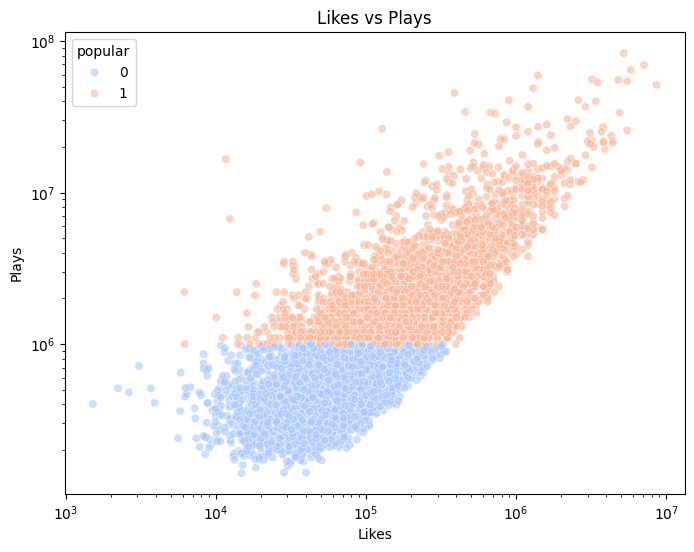

In [12]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='likes', y='plays', hue='popular', palette='coolwarm', alpha=0.6)
plt.title('Likes vs Plays')
plt.xlabel('Likes')
plt.ylabel('Plays')
plt.xscale('log')
plt.yscale('log')
plt.show()


g. Visualisasi WordCloud Hashtag

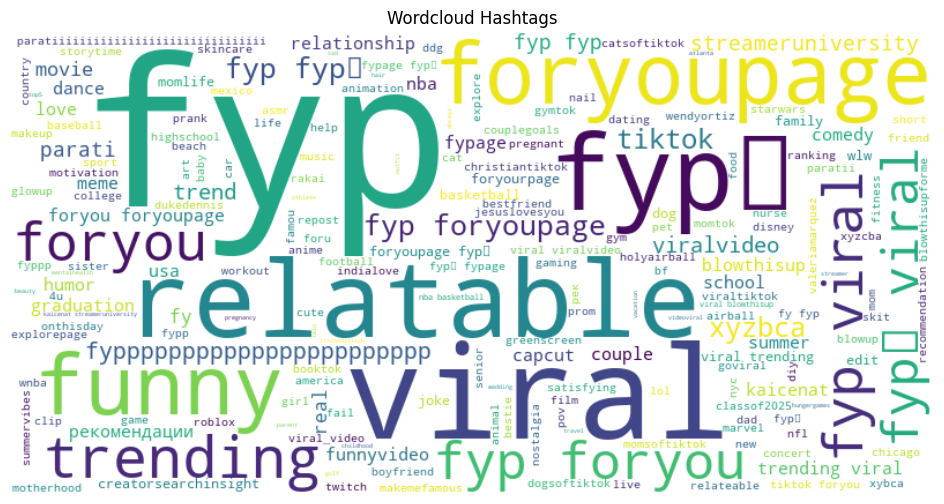

In [13]:
text = ' '.join(df['hashtags'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Wordcloud Hashtags")
plt.show()


h. Visualisasi Kolom Numerik

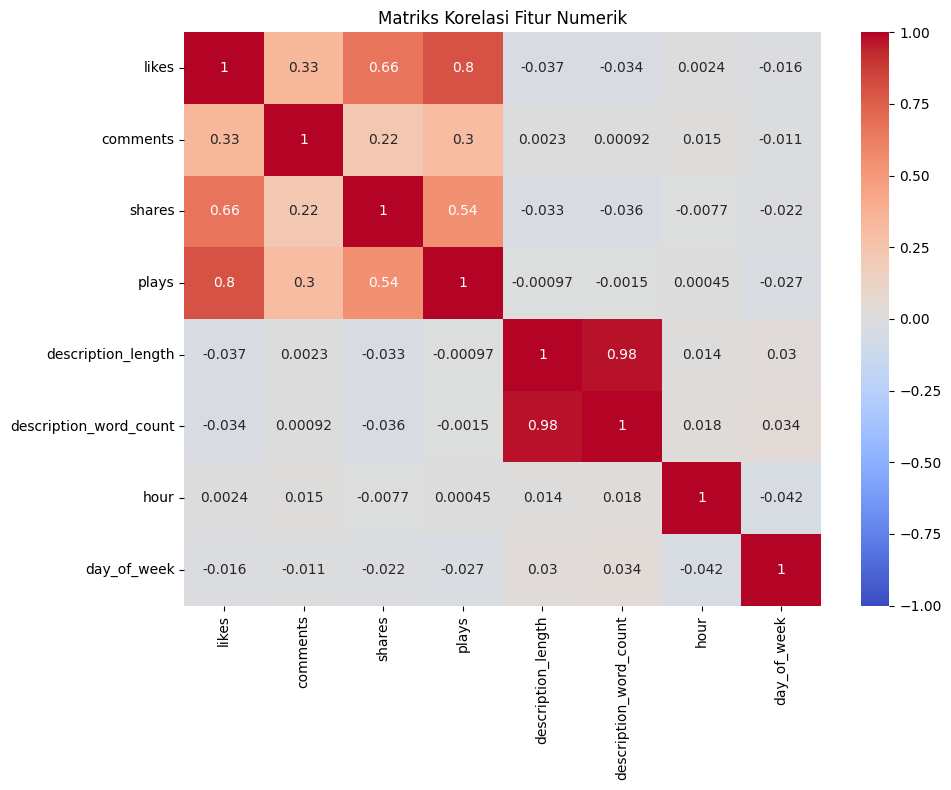

In [14]:
numeric_cols = ['likes', 'comments', 'shares', 'plays', 
                'description_length', 'description_word_count', 
                'hour', 'day_of_week']
clean_data = df[numeric_cols].replace([np.inf, -np.inf], np.nan).dropna()
corr_matrix = clean_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriks Korelasi Fitur Numerik")
plt.tight_layout()
plt.show()


i. Visualisasi Penggunaan Musik pada Konten Populer

C:\Users\HP ELITEBOOK 845 G7\AppData\Local\Temp\ipykernel_27088\2404065245.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Musik', loc='upper right', frameon=False)  # Atur legend jika perlu


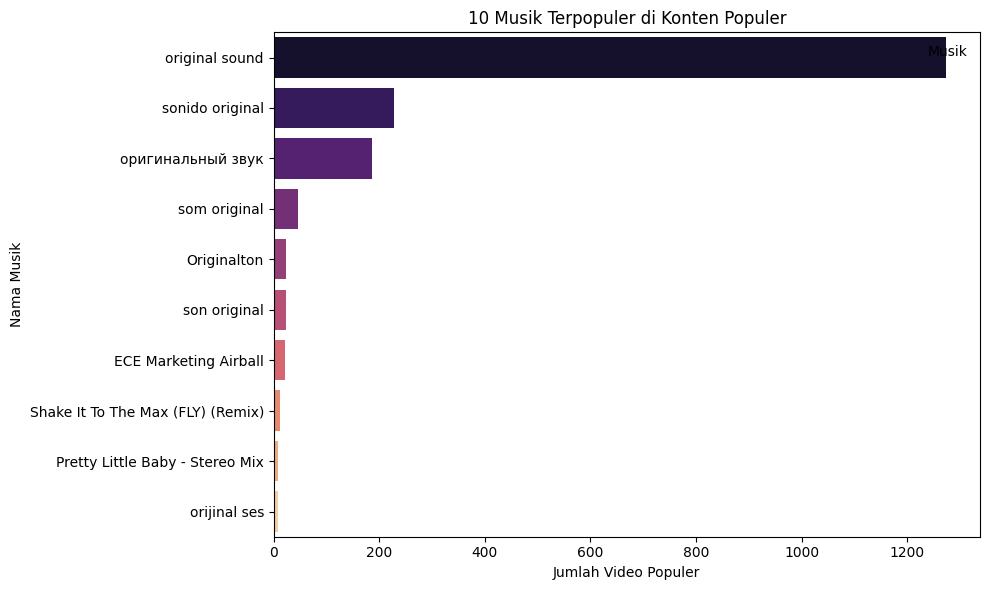

In [31]:
# Visualisasi dengan hue dan legend disembunyikan
plt.figure(figsize=(10, 6))
sns.barplot(
    y=top_music_popular.index,
    x=top_music_popular.values,
    hue=top_music_popular.index,  # Menambahkan hue
    palette='magma',
    dodge=False  # Pastikan untuk mengatur dodge jika diperlukan
)
plt.title('10 Musik Terpopuler di Konten Populer')
plt.xlabel('Jumlah Video Populer')
plt.ylabel('Nama Musik')
plt.tight_layout()
plt.legend(title='Musik', loc='upper right', frameon=False)  # Atur legend jika perlu
plt.show()

C:\Users\HP ELITEBOOK 845 G7\AppData\Local\Temp\ipykernel_27088\4185018261.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


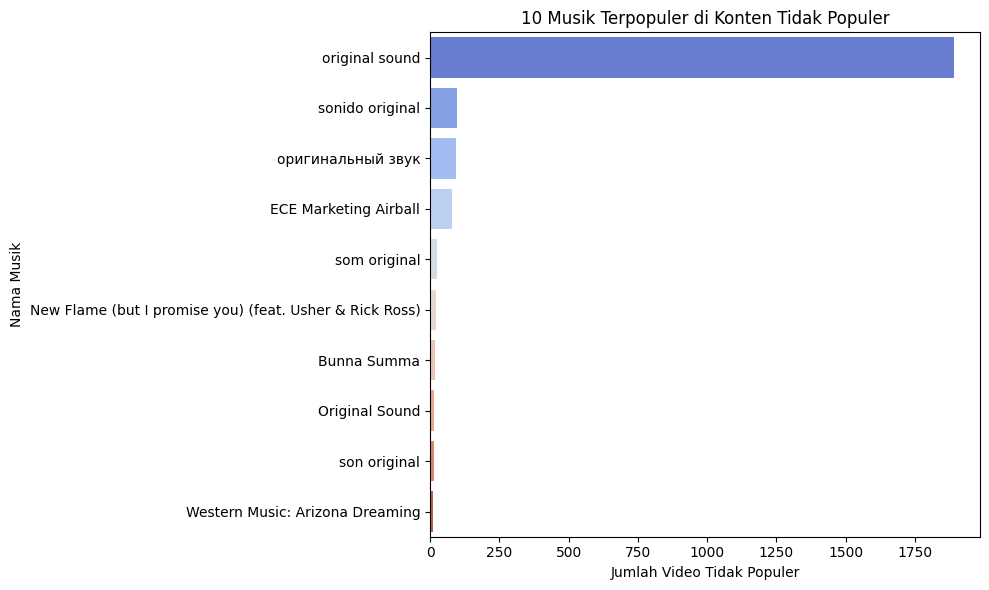

In [32]:
# Hitung jumlah kemunculan musik dalam konten tidak populer
top_music_not_popular = (
    df[df['popular'] == 0]['music']
    .value_counts()
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(
    y=top_music_not_popular.index,
    x=top_music_not_popular.values,
    palette='coolwarm'
)
plt.title('10 Musik Terpopuler di Konten Tidak Populer')
plt.xlabel('Jumlah Video Tidak Populer')
plt.ylabel('Nama Musik')
plt.tight_layout()
plt.show()


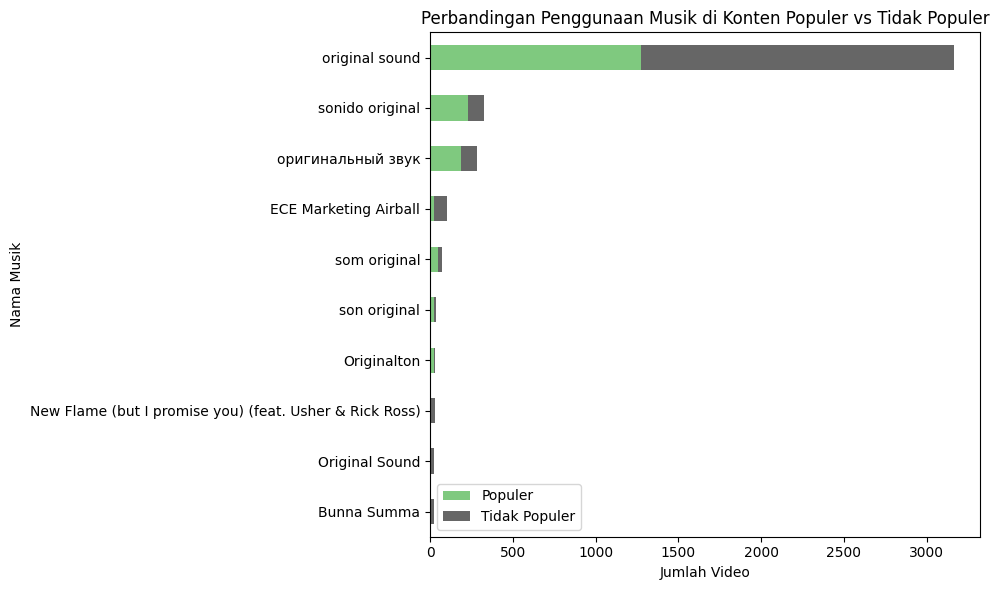

In [33]:
# Gabungkan dua dataframe musik populer dan tidak populer
music_popular = df[df['popular'] == 1]['music'].value_counts()
music_not_popular = df[df['popular'] == 0]['music'].value_counts()

# Gabungkan ke dalam satu DataFrame
music_compare = pd.DataFrame({
    'Populer': music_popular,
    'Tidak Populer': music_not_popular
}).fillna(0)

# Ambil 10 musik paling umum secara total
music_compare['Total'] = music_compare['Populer'] + music_compare['Tidak Populer']
top10_music = music_compare.sort_values('Total', ascending=False).head(10)

# Visualisasi
top10_music[['Populer', 'Tidak Populer']].plot(
    kind='barh', 
    figsize=(10, 6), 
    stacked=True, 
    colormap='Accent'
)
plt.title('Perbandingan Penggunaan Musik di Konten Populer vs Tidak Populer')
plt.xlabel('Jumlah Video')
plt.ylabel('Nama Musik')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Algoritma Random Forest

1. Seleksi Fitur

In [ ]:
features = ['likes', 'comments', 'shares', 'description_length', 'description_word_count',
            'author_encoded', 'music_encoded', 'hour', 'day_of_week']
X_numeric = df[features]
X_all = hstack([X_numeric, tfidf_matrix])
y = df['popular']

2. Pembagian Data (Split Data)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42, stratify=y)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (5221, 109)
Shape of X_test: (1306, 109)


3. Melatih Model

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rf.predict(X_test)

4. Metrik Evaluasi

In [ ]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Displaying Metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Classification Report
report = classification_report(y_test, y_pred, output_dict=True)
print(pd.DataFrame(report).T.round(2)) 

Accuracy: 0.82
Precision: 0.84
Recall: 0.74
F1 Score: 0.79
              precision  recall  f1-score  support
0                  0.81    0.88      0.84   711.00
1                  0.84    0.74      0.79   595.00
accuracy           0.82    0.82      0.82     0.82
macro avg          0.82    0.81      0.82  1306.00
weighted avg       0.82    0.82      0.82  1306.00


5. Confusion Matrix

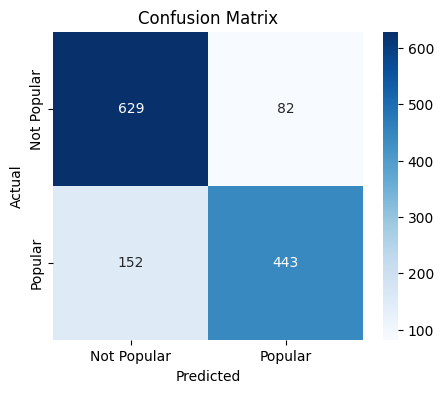

In [ ]:
# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Popular', 'Popular'],
            yticklabels=['Not Popular', 'Popular'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

6. Simpan Model

In [ ]:
import os

# Simpan model Random Forest
joblib.dump(rf, 'models/rf_model.pkl')
# Simpan encoder LabelEncoder
joblib.dump(le_author, 'models/le_author.pkl')
joblib.dump(le_music, 'models/le_music.pkl')

# Simpan TF-IDF Vectorizer untuk hashtag
joblib.dump(tfidf, 'models/tfidf_hashtag.pkl')

print("Model dan encoder berhasil disimpan ke folder 'models/'")


Model dan encoder berhasil disimpan ke folder 'models/'
